# Simplify SPMe+SEI Model 

The main purpose of this section is to reformulate the SPMe+RF model from. 

Assumptions:

<ol>
    <li> The diffusivity parameter of lithium ion in the negative particle is constant.</li>
    <li> The concentration of lithium ions in the electrolyte is constant.</li>
    <li> The conductivity and transport efficiency of the electrolyte are also constant </li>
    </ol>

$$  
\begin{equation}
\frac{d \bar{\hat{c}}_{\mathrm{n0}}}{d\hat{t}}=\frac{-3}{\alpha_n }\hat{J}_\mathrm{n}^\mathrm{total}.
\end{equation}
$$

$$
 \frac{\partial \varepsilon_\mathrm{n}}{\partial t}= \frac{M_\mathrm{SR}}{n_\mathrm{SR} \rho_\mathrm{SR} F} \bar{J}_\mathrm{SR},
 $$
$$
  L_\mathrm{f, n}=L_\mathrm{f,n,init}-\frac{1}{a_\mathrm{n}}(\varepsilon_\mathrm{n}-\varepsilon_\mathrm{n, init}) 
 $$
 
$$
    J_\mathrm{n}^{\mathrm{total}}=\frac{i_\mathrm{app}}{L_\mathrm{n}}-\bar{J}_\mathrm{SR}, 
$$

$$
    \bar{J}_\mathrm{SR}=\frac{1}{L_\mathrm{n}} \int_0^{L_\mathrm{n}} J_\mathrm{SR} d\scriptstyle{\mathcal{X}},
$$

$$
    J_{\mathrm{SR}}=-a_\mathrm{n} j_\mathrm{SR} \mathrm{exp}\left(-\alpha_\mathrm{SR}\frac{F}{RT} \left(\phi_\mathrm{n}-\phi_\mathrm{e}-U_\mathrm{SR}-\frac{i_\mathrm{app}L_\mathrm{f, n}}{a_\mathrm{n} \sigma_\mathrm{f, n} L_\mathrm{n}} \right ) \right ).
$$

\begin{equation}
\begin{aligned}
&\phi_\mathrm{n}=U_\mathrm{n}(\bar{c}_\mathrm{n}|_{r=R_{n}}) \\
  &\phi_e=- \frac{i_\mathrm{app} }{6 \sigma_\mathrm{e} {\scriptstyle\mathcal{B}} L_n}\scriptstyle\mathcal{X}^3
  \end{aligned}
\end{equation}

So, Basically we are trying two solve DAEs with (1,2 3, 6, 7) for the variables $\bar{c}$, $\varepsilon$, $L_\mathrm{f, n}$,  $\phi_e$ and $\phi_n$ with approperiate initial conditions. For Simiplicity (now) we only conider first terms for $\phi_e$ and $\phi_n$.

In [17]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import time
# import scipy.sparse as sparse
# pybamm.__version__

In [18]:
param_SPMe = pybamm.ParameterValues("Chen2020")
param_SPMe

{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': 0.2594,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0,
 'Current function [A]': 5.0,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_Nyman2008 at 0x7f8907f53250>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diffusivity_Nyman2008 at 0x7f8907f536d0>,
 'Electron charge [C]': 1.602176634e-19,
 'Faraday constant [C.mol-1]': 96485.33212,
 'Ideal gas constant [J.K-1.mol-1]': 8.314462618,
 'Initial concentration in electrolyte [mol.m-3]': 1000.0,
 'Initial concentration in negative electrode [mol.m-3]': 29866.0,
 'Initial conce

In [19]:
# Runnung SPMe in PyBaMM
param_SPMe = pybamm.ParameterValues("Chen2020")
param_SPMe['Initial inner SEI thickness [m]'] = 5e-13
param_SPMe['Initial outer SEI thickness [m]'] = 5e-13

c_rate = 50  # Charging and discharging rate
cycle_number = 1
exp_CCCV_CC = pybamm.Experiment(
    [("Charge at C/{} until 4.2 V".format(c_rate),
      #    "Rest for 10 hours",
      # "Discharge at C/{} until 2.5 V".format(c_rate),
      )] * cycle_number


)

var_pts = {
    "x_n": 20,  # negative electrode
    "x_s": 20,  # separator
    "x_p": 20,  # positive electrode
    "r_n": 20,  # negative particle
    "r_p": 20,  # positive particle
}
SEIModels = ["reaction limited"]
SEIModels = ["interstitial-diffusion limited"]
models = []
solutions_SPMe = []
for index in range(len(SEIModels)):
    models.append(pybamm.lithium_ion.SPM(
        {
            "SEI": SEIModels[index],
            "SEI porosity change": "true",
            "SEI film resistance": "average"
        }))
    # "x-average side reactions": "true"
    # sim = pybamm.Simulation(models[index], parameter_values=param, experiment=exp, var_pts=var_pts)
    # solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6)
    solver = pybamm.IDAKLUSolver()
    sim = pybamm.Simulation(models[index], parameter_values=param_SPMe,
                            experiment=exp_CCCV_CC, var_pts=var_pts,  solver=solver)
    # start_time = time.time()
    sol = sim.solve(initial_soc=0)
    # solutions_SPMe.append(sim.solve(initial_soc = 0))
    # end_time = time.time()
    solutions_SPMe.append(sol)
    # execution_time = end_time - start_time

# print(f"Execution time: {execution_time} seconds")
print(f"Solve time: {solutions_SPMe[0].solve_time} seconds")
print(f"Setup time: {solutions_SPMe[0].set_up_time} seconds")
# solutions_SPMe[0].cycles[0].plot(["Current [A]","Voltage [V]"])

sol_SPMe = []
# sol_SPMe.append(solutions_SPMe[0]['Negative electrode volume-averaged concentration [mol.m-3]'].entries)
# sol_SPMe.append(solutions_SPMe[0]['Positive electrode volume-averaged concentration [mol.m-3]'].entries)
sol_SPMe.append(
    solutions_SPMe[0]['X-averaged negative particle surface concentration [mol.m-3]'].entries)
sol_SPMe.append(
    solutions_SPMe[0]['X-averaged positive particle surface concentration [mol.m-3]'].entries)

sol_SPMe.append(-solutions_SPMe[0]
                ["Negative electrolyte potential [V]"].entries[0])
sol_SPMe.append(
    solutions_SPMe[0]['X-averaged negative electrode porosity'].entries)
sol_SPMe.append(solutions_SPMe[0]['X-averaged SEI thickness [m]'].entries)
# sol_SPMe.append(solutions_SPMe[0]['X-averaged negative electrode potential [V]'].entries)
# sol_SPMe.append(solutions_SPMe[0]['X-averaged SEI interfacial current density [A.m-2]'].entries)
sol_SPMe.append(solutions_SPMe[0]["Voltage [V]"].entries)

# # sol_SPMe.append(solutions_SPMe[0]['X-averaged negative electrode SEI interfacial current density [A.m-2]'].entries),
# # sol_SPMe.append(solutions_SPMe[0]['X-averaged SEI film overpotential [V]'].entries ),


# sol_SPMe.append(solutions_SPMe[0]["Voltage [V]"].entries)
t = solutions_SPMe[0]["Time [s]"].entries

Solve time: 125.857 ms seconds
Setup time: 29.960 ms seconds


In [20]:
# Simplified Model
# Defininig variables
from pybamm import exp
from pybamm import tanh
cn_av = pybamm.Variable("Negative concentration [mol.m-3]")
cp_av = pybamm.Variable("Positive concentration [mol.m-3]")
phi_n = pybamm.Variable("Negative electrode potential [V]")
phi_p = pybamm.Variable("Positive electrode potential [V]")
phi_e_n = pybamm.Variable("Negative electrolyte potential [V]")
E_n = pybamm.Variable("Negative electrode porosity")
L_SEI = pybamm.Variable("Thickness of SEI [m]")
J_SEI = pybamm.Variable("SEI interfacial current density [A.m-2]")


x_n = pybamm.SpatialVariable(
    "x_n", domain=["negative electrode"], coord_sys="cartesian")


# dimensional pybamm.Parameter(eters)
R_n = pybamm.Parameter('Negative particle radius [m]')
R_p = pybamm.Parameter('Positive particle radius [m]')
T = pybamm.Parameter('Initial temperature [K]')
R = pybamm.Parameter('Ideal gas constant [J.K-1.mol-1]')
F = pybamm.Parameter("Faraday constant [C.mol-1]")
cn0 = pybamm.Parameter('Initial concentration in negative electrode [mol.m-3]')
cp0 = pybamm.Parameter('Initial concentration in positive electrode [mol.m-3]')
c_e = pybamm.Parameter('Initial concentration in electrolyte [mol.m-3]')
L_n = pybamm.Parameter("Negative electrode thickness [m]")
L_p = pybamm.Parameter("Positive electrode thickness [m]")
I_app = pybamm.Parameter("Applied current [A]")
j_SEI_0 = pybamm.Parameter(
    'Initial SEI reaction exchange current density [A.m-2]')
an = pybamm.Parameter('Negative particle surface area to volume ratio [m-1]')
ap = pybamm.Parameter('Positive particle surface area to volume ratio [m-1]')
U_SEI = pybamm.Parameter('SEI open-circuit potential [V]')
s_SEI = pybamm.Parameter("SEI conductivity [S.m-1]")
L_SEI_0 = pybamm.Parameter("Initial SEI thickness [m]")
alpha_SEI = pybamm.Parameter("alpha_SEI [-]")
sigma_e = pybamm.Parameter('Electrolyte conductivity [S.m-1]')
B = pybamm.Parameter('Negative electrode Bruggeman coefficient (electrolyte)')
E_init = pybamm.Parameter('Initial negative electrode porosity')
M_SEI = pybamm.Parameter("Molar weight of SEI material [kg.mol-1]")
rho_SEI = pybamm.Parameter("Density of SEI material [kg.m-3]")
n_SEI = pybamm.Parameter("electrone number [-]")
c_n_max = pybamm.Parameter(
    "Maximum concentration in negative electrode [mol.m-3]")
c_p_max = pybamm.Parameter(
    "Maximum concentration in positive electrode [mol.m-3]")

L_Z = pybamm.Parameter('Electrode height [m]')
L_Y = pybamm.Parameter('Electrode width [m]')


D_Lii = pybamm.Parameter('SEI lithium interstitial diffusivity [m2.s-1]')
C_Lii = pybamm.Parameter(
    'Lithium interstitial reference concentration [mol.m-3]')


def Un(x):
    return pybamm.FunctionParameter(
        "Negative electrode OCP [V]",
        {"Negative particle stoichiometry": x},
    )


def Up(x):
    return pybamm.FunctionParameter(
        "Positive electrode OCP [V]",
        {"Positive particle stoichiometry": x},
    )


def ch_dch(x):
    return pybamm.FunctionParameter(
        "ch_dch_I_app",
        {"Positive particle stoichiometry": x},
    )


def OCP_n(sto):
    stretch = 1.00
    # sto = stretch * cc / c_n_max
    u_eq = (
        1.9793 * exp(-39.3631 * sto)
        + 0.2482
        - 0.0909 * tanh(29.8538 * (sto - 0.1234))
        - 0.04478 * tanh(14.9159 * (sto - 0.2769))
        - 0.0205 * tanh(30.4444 * (sto - 0.6103))
    )
    return u_eq


def OCP_P(sto):
    u_eq = (
        -0.8090 * sto
        + 4.4875
        - 0.0428 * tanh(18.5138 * (sto - 0.5542))
        - 17.7326 * tanh(15.7890 * (sto - 0.3117))
        + 17.5842 * tanh(15.9308 * (sto - 0.3120))
    )
    return u_eq


def my_current(t):
    return pybamm.sign(180000-t)


param_simplified = pybamm.ParameterValues(
    {'Negative particle radius [m]': 5.86e-06,  # from Chen2020
     'Positive particle radius [m]': 5.22e-06,
     'Initial temperature [K]': 298.15,  # from Chen2020
     'Ideal gas constant [J.K-1.mol-1]': 8.314462618,   # from Chen2020
     "Faraday constant [C.mol-1]": 96485.33212,  # from Chen2020
     'Initial concentration in negative electrode [mol.m-3]': solutions_SPMe[0]['Negative electrode volume-averaged concentration [mol.m-3]'].entries[0],
     'Initial concentration in positive electrode [mol.m-3]': solutions_SPMe[0]['Positive electrode volume-averaged concentration [mol.m-3]'].entries[0],
     'Initial concentration in electrolyte [mol.m-3]': 1000,
     "Negative electrode thickness [m]": 8.52e-05,  # from Chen2020
     'Positive electrode thickness [m]': 7.56e-05,
     "Applied current [A]": 0,  # managed during running the code
     # from Chen2020
     'Initial SEI reaction exchange current density [A.m-2]': 1.5e-07,
     # From Ferran AMM 2023 checked with chen2020
     'Positive particle surface area to volume ratio [m-1]': 3.82e5,
     # From Ferran AMM 2023 checked with chen2020
     'Negative particle surface area to volume ratio [m-1]': 3.84e5,
     'SEI open-circuit potential [V]':  0.4,  # from Chen2020
     # From Ferran AMM 2023 same as in Chen2020 (Resistivity)
     "SEI conductivity [S.m-1]": 5e-6,
     "Initial SEI thickness [m]": 1e-12,
     "alpha_SEI [-]": 0.5,
     'Electrolyte conductivity [S.m-1]': 0.9486,
     # from Chen2020
     'Negative electrode Bruggeman coefficient (electrolyte)': 1.5,
     'Initial negative electrode porosity': 0.25,  # from Chen2020
     "Molar weight of SEI material [kg.mol-1]": 0.162,  # From Ferran AMM 2023
     # From Ferran AMM 2023   M/rho=Volume = Chen 2020
     "Density of SEI material [kg.m-3]": 1690,
     "electrone number [-]": 2,  # from Chen2020
     # from Chen2020
     "Maximum concentration in negative electrode [mol.m-3]": 33133.0,
     "Maximum concentration in positive electrode [mol.m-3]": 63104.0,
     'Electrode height [m]': 0.065,  # Chen2020
     'Electrode width [m]': 1.58,  # Chen2020
     "Negative electrode OCP [V]": OCP_n,
     "Positive electrode OCP [V]": OCP_P,
     # "electrolyte_conductivity [S m-1]": sigma_e


     'SEI lithium interstitial diffusivity [m2.s-1]': 1e-20,
     'Lithium interstitial reference concentration [mol.m-3]': 15.0,


     "ch_dch_I_app": ch_dch,



     }
)

model_simplified = pybamm.lithium_ion.BaseModel()
param_simplified['Applied current [A]'] = solutions_SPMe[0]['Current [A]'].entries[0] / \
    (L_Y*L_Z)

if SEIModels[0] == "reaction limited":
    J_SEI = -an * j_SEI_0 * \
        exp(-alpha_SEI*F/(R*T) * (phi_n - phi_e_n -
            U_SEI - (I_app*L_SEI/s_SEI)))
    J_SEI_AV = pybamm.x_average(J_SEI)
elif SEIModels[0] == "interstitial-diffusion limited":
    J_SEI = -F*D_Lii*C_Lii/(.5*L_SEI) * exp(-F/(R*T) * (phi_n - phi_e_n))*an
    J_SEI_AV = pybamm.x_average(J_SEI)


model_simplified.variables = {
    "Negative concentration [mol.m-3]": cn_av,
    "Positive concentration [mol.m-3]": cp_av,
    "Negative electrode potential [V]": phi_n,
    "Positive electrode potential [V]": phi_p,
    "Negative electrolyte potential [V]":  phi_e_n,
    "Negative electrode porosity": E_n,
    "Thickness of SEI [m]": L_SEI,
    "SEI interfacial current density [A.m-2]": I_app,


}


model_simplified.algebraic = {
    phi_n: phi_n - Un(cn_av/c_n_max),
    phi_p: phi_p - Up(cp_av/c_p_max) + Un(cn_av/c_n_max),
    phi_e_n: phi_e_n + I_app/(2.0*sigma_e*B*L_n)*L_n**2,
    L_SEI: L_SEI - L_SEI_0 + 1/an*(E_n-E_init),
}

dcndt = -3/(an*R_n*F)*(I_app/L_n - J_SEI)
dcpdt = 3/(ap*R_p*F)*(I_app/L_p)
dEndt = M_SEI/(n_SEI*rho_SEI*F)*J_SEI


model_simplified.rhs = {cn_av: dcndt, E_n: dEndt, cp_av: dcpdt}


model_simplified.initial_conditions = {
    phi_n: Un(cn0/c_n_max),
    phi_p: Un(cp0/c_p_max)-Un(cn0/c_n_max),
    phi_e_n: 1e-7,
    L_SEI: L_SEI_0,
    cn_av: cn0,
    cp_av: cp0,
    E_n: E_init,
}

geometry = {
    "negative electrode": {x_n: {"min": 0, "max": L_n}},
}

param_simplified.process_model(model_simplified)
param_simplified.process_geometry(geometry)


submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
}
var_pts = {x_n: 20}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

spatial_methods = {
    "negative electrode": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model_simplified)


# solver = pybamm.CasadiSolver()
solver = pybamm.IDAKLUSolver()
# t = np.linspace(0, 80000, 20000)


# start_time = time.time()
sim_k = pybamm.Simulation(
    model_simplified, parameter_values=param_simplified, solver=solver)
solution_simplified = sim_k.solve(t)
# end_time = time.time()
# execution_time = end_time - start_time

# print(f"Execution time: {execution_time} seconds")
print(f"Execution time: {solution_simplified.solve_time} seconds")

# print(np.sum(solution_simplified["SEI interfacial current density [A.m-2]"].entries))

Execution time: 62.718 ms seconds


In [21]:
# ch_dch =  solution_simplified["SEI interfacial current density [A.m-2]"].entries
# cc = solution_simplified["Negative concentration [mol.m-3]"].entries
# plt.plot(cc, ch_dch)

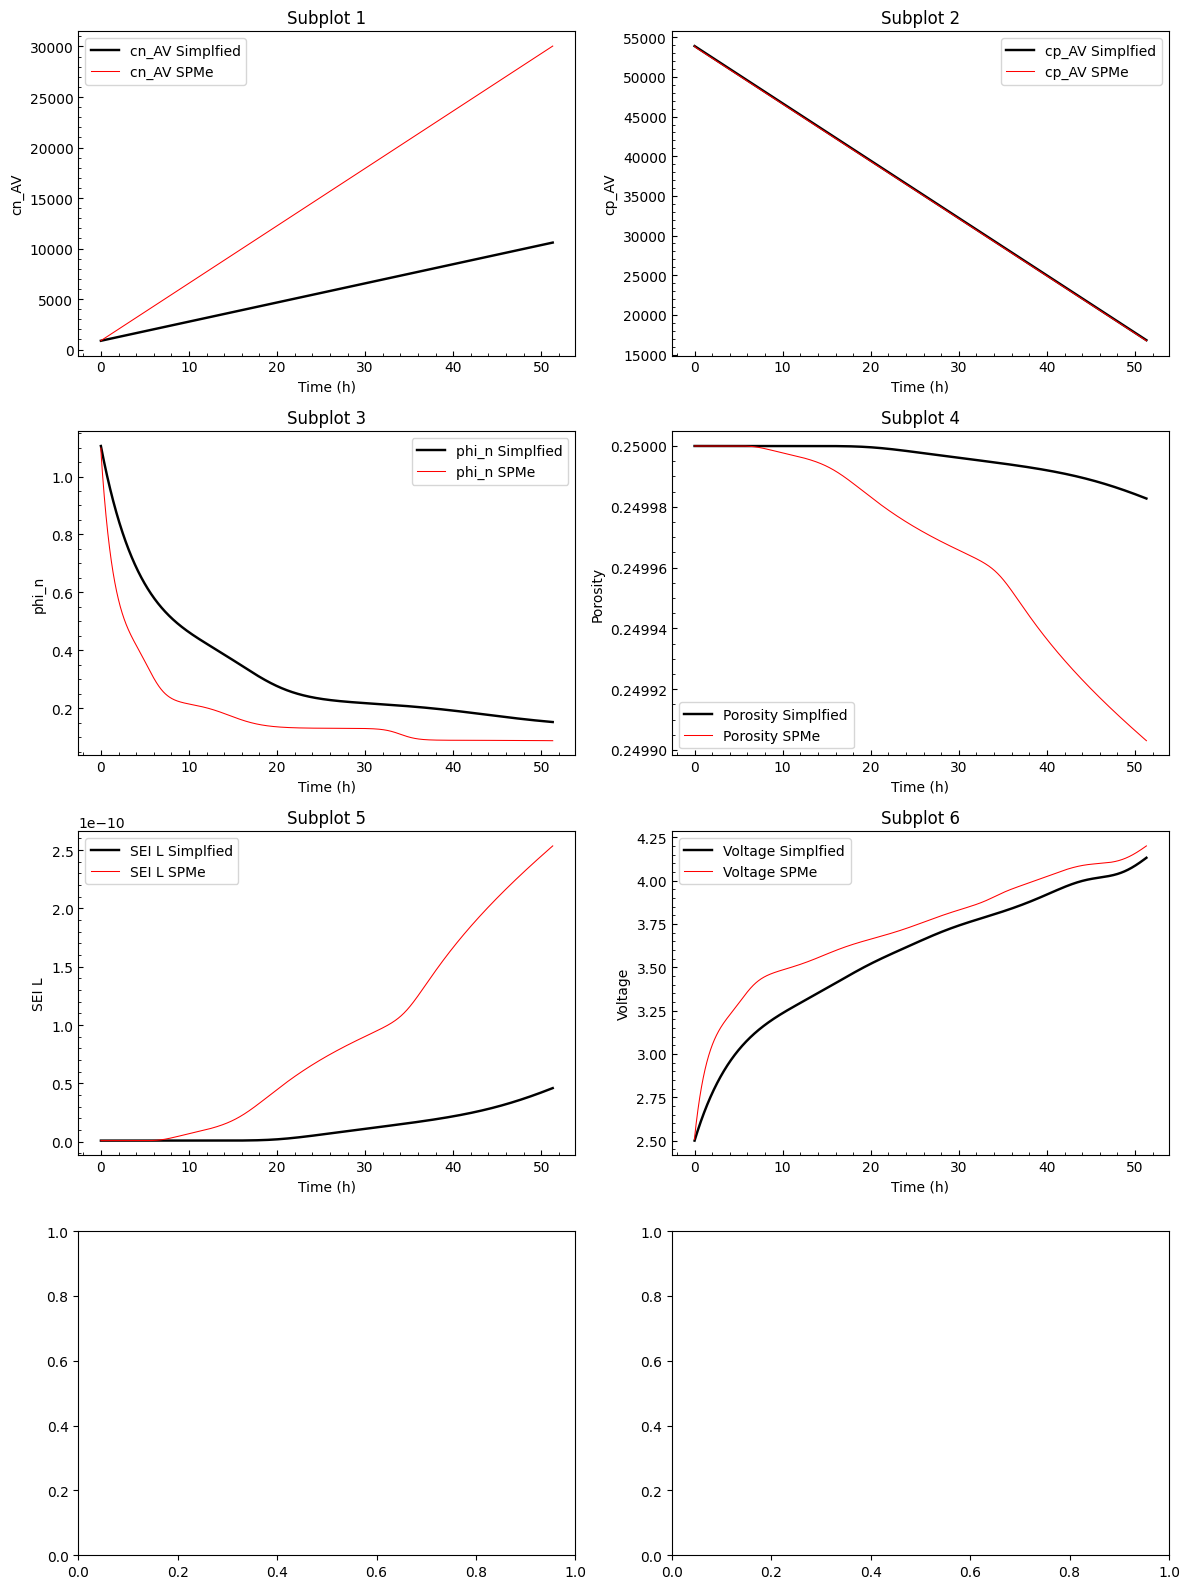

In [22]:
sol = []
tt = (solution_simplified.t/3600)
an = param_simplified['Negative particle surface area to volume ratio [m-1]']
sol.append(solution_simplified["Negative concentration [mol.m-3]"].entries)
sol.append(solution_simplified["Positive concentration [mol.m-3]"].entries)
sol.append(solution_simplified["Negative electrode potential [V]"].entries)
sol.append(solution_simplified["Negative electrode porosity"].entries)
sol.append(solution_simplified["Thickness of SEI [m]"].entries)
# sol.append(solution_simplified["Negative electrolyte potential [V]"].entries)
# sol.append(solution_simplified["SEI interfacial current density [A.m-2]"].entries / an)
sol.append(solution_simplified["Positive electrode potential [V]"].entries)


# print(np.max(sol[0]))
# sol.append(solution_simplified['X-averaged SEI film overpotential [V]'].entries[0])
# sol.append(solution_simplified["Voltage [V]"].entries)


Label = ["cn_AV", "cp_AV", "phi_n", "Porosity", "SEI L", "Voltage"]

fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for i in range(6):  # Loop through the data to plot in subplots
    row = i // 2
    col = i % 2
    ax = axes[row, col]

    ax.plot(tt,
            sol[i],
            label=Label[i]+" Simplfied",
            linestyle="-",
            color="black",
            linewidth=1.75)

    ax.plot(tt,
            sol_SPMe[i],
            label=Label[i]+" SPMe",
            linestyle="-",
            color="red",
            linewidth=0.75)
    ax.set_title("Subplot " + str(i+1))
    ax.set_xlabel("Time (h)")
    ax.set_ylabel(Label[i])
    ax.legend()
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in')

    # Add minor ticks

# ax.grid(which='minor', linestyle='--', linewidth=0.5)
# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

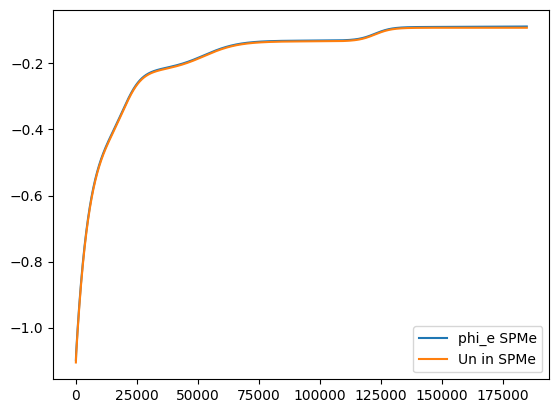

In [23]:
tt = solution_simplified.t
phi_e = solutions_SPMe[0]["Negative electrolyte potential [V]"].entries[0]
OCP_n = solutions_SPMe[0]['Negative electrode open-circuit potential [V]'].entries[0]

# En=solution["Concentration [mol.m-3]"].entries
# # L_SEI=solution["Thickness of SEI [m]"].entries
# # L_SEI: L_SEI_0-1/an*(En-E_init)
# plt.plot(tt,cc)
# v=phin - phie


plt.plot(tt, phi_e, label="phi_e SPMe")
plt.plot(tt, -OCP_n, label="Un in SPMe")
plt.legend()
plt.show()
# # plt.plot(tt,L_SEI[0,:])

In [24]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Ferran Brosa Planella and W. Dhammika Widanage. Systematic derivation of a Single Particle Model with Electrolyte and Side Reactions (SPMe+SR) for degradation of lithium-ion batteries. Submitted for publication, ():, 2022. doi:.
[3] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for Parameterization of Multi-scale Lithium-ion Battery Models. Journal of The Electrochemical Society, 167(8):080534, 2020. doi:10.1149/1945-7111/ab9050.
[4] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array program